<a href="https://colab.research.google.com/github/joannawqy/ECON323/blob/main/FinalProject_2slslasso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## An Investigation into the Impact of GDP on a Country's University Ranking Performance

Group members: Xinxiao Liu, Joanna Wang, Jiaqi Zhou, Lucy Zhu

## Introduction

University rankings, while not an accurate measure of a university's overall performance, offer insights into aspects like student employment, academic achievement, and global standing. These rankings often influence perceptions of both universities and their students, particularly in the context of graduate school applications. Sometimes, the country in which a university is located appears to play a crucial role in determining its ranking. For instance, in the QS ranking, there has been notable progress in the rankings of Chinese universities and a decline for Japanese universities. American and UK universities consistently achieve high rankings and occupy many spots on the ranking lists. This observation raises the question: do some characteristics of a country, where a university is located, significantly contribute to its ranking? This project aims to explore the impact of GDP—including per capita GDP, GDP in 2010 US dollars, and GDP growth—on the university rankings of a country.

## Load Packages

In [ ]:
!pip install linearmodels

In [43]:
%matplotlib inline

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from linearmodels.iv import IV2SLS

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LassoCV, lasso_path, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import pipeline



## Data Selection

In this project, our data selection spans the years 2017 to 2022 and includes the following components:

- Exogenous Variable: QS World University Rankings. For this part, we will create a unique University Ranking Index for the top 200 universities. This index will allocate a score to universities based on their QS ranking: the top-ranked university will receive a score of 200, the second-ranked 199, and so forth, down to the 200th ranked university, which will receive a score of 1. Each country's annual aggregate index score will be determined by the cumulative scores of its universities.

- Regressor of Interest:
GDP per capita (constant 2010 dollars),
Gross Domestic Product (in billions of 2010 U.S. dollars),
Economic Growth (measured as the rate of change of real GDP).

- Control Covariates:
Capital Investment (as percent of GDP and in billion USD),
Household Consumption (as percent of GDP and in billion USD),
Labor Force (in million people),
Government Spending (as percent of GDP and in billion USD),
Population Growth (percent),
Happiness Index (scale 0 for unhappy to 10 for happy),
Unemployment Rate,
Exports of Goods and Services (in billion USD and annual growth rate),
Current Account Balance (in billion USD).

## Data Wrangling

### step1: head the dataset to have an overview of it

In [ ]:
ranking = pd.read_csv('qs-world-university-rankings-2017-to-2022-V2.csv')

In [ ]:
ranking.head()

,university,year,rank_display,score,link,country,city,region,logo,type,research_output,student_faculty_ratio,international_students,size,faculty_count
0,Massachusetts Institute of Technology (MIT),2017,1,100.0,https://www.topuniversities.com/universities/m...,United States,Cambridge,North America,https://www.topuniversities.com/sites/default/...,Private,Very High,4.0,"3,730",M,"3,065"
1,Stanford University,2017,2,98.7,https://www.topuniversities.com/universities/s...,United States,Stanford,North America,https://www.topuniversities.com/sites/default/...,Private,Very High,3.0,"3,879",L,"4,725"
2,Harvard University,2017,3,98.3,https://www.topuniversities.com/universities/h...,United States,Cambridge,North America,https://www.topuniversities.com/sites/default/...,Private,Very High,5.0,"5,877",L,"4,646"
3,University of Cambridge,2017,4,97.2,https://www.topuniversities.com/universities/u...,United Kingdom,Cambridge,Europe,https://www.topuniversities.com/sites/default/...,Public,Very high,4.0,"7,925",L,"5,800"
4,California Institute of Technology (Caltech),2017,5,96.9,https://www.topuniversities.com/universities/c...,United States,Pasadena,North America,https://www.topuniversities.com/sites/default/...,Private,Very High,2.0,692,S,968


In [ ]:
ranking.dtypes

university                 object
year                        int64
rank_display               object
score                     float64
link                       object
country                    object
city                       object
region                     object
logo                       object
type                       object
research_output            object
student_faculty_ratio     float64
international_students     object
size                       object
faculty_count              object
dtype: object

### step2: extract top 200 ranking universities of each year and add ranking index to the universities in each year, then aggregate them by country

In [ ]:
# create a dictionary to store the top 200 universities for each year
top_200_per_year = {}
# create a list to store the aggregated data frames for all years
aggregated_dataframes_all_years = []
for year_number in range(2017, 2023):  # Include 2022 as well
    # Using boolean indexing to select rows for each year
    data_year=ranking[ranking['year'] == year_number]
    # Select columns of interest
    data_year = data_year[['university', 'year', 'rank_display', 'country', 'region']]
    # Convert rank_display to a numeric value
    data_year['rank_display'] = pd.to_numeric(data_year['rank_display'], errors='coerce')
    # Sort the data by the numeric rank and keep the top 200 universities
    top_200 = data_year.sort_values('rank_display').head(200)
    # Generate the ranking index in reverse to make sure higher ranking has bigger index
    top_200['ranking index'] = np.arange(200, 0, -1)[:len(top_200)]
    # Store in the top_200_per_year dictionary
    top_200_per_year[year_number] = top_200
    # Sort the ranking index by country and sum them up
    aggregated_data = top_200.groupby('country')['ranking index'].sum().reset_index()
    # Add a year column to the aggregated data
    aggregated_data['year'] = year_number
    # Rearrange columns in the order: country, year, ranking index
    aggregated_data = aggregated_data[['country', 'year', 'ranking index']]
    # Append to the list
    aggregated_dataframes_all_years.append(aggregated_data)

### step3: combine the data and select countries that appear in all years

In [ ]:
# Concatenate all the data frames in the list into a single data frame
combined_aggregated_data = pd.concat(aggregated_dataframes_all_years, ignore_index=True)
# Keep the countries that appear in all six years
countries_in_all_years = combined_aggregated_data['country'].value_counts()
countries_in_all_years = countries_in_all_years[countries_in_all_years == 6].index.tolist()
# Filter the combined_aggregated_data to include only these countries
filtered_aggregated_data = combined_aggregated_data[combined_aggregated_data['country'].isin(countries_in_all_years)]
# The filtered_aggregated_data now contains only the countries that appear in all 6 years (from 2017 to 2022)

In [ ]:
filtered_aggregated_data.head()

,country,year,ranking index
0,Argentina,2017,116
1,Australia,2017,1110
2,Austria,2017,63
3,Belgium,2017,257
4,Brazil,2017,90


Add covariates from another 2 datasets

In [ ]:
variable_data = pd.read_csv('variable_data_copy.csv')
variable_data.fillna('North America', inplace=True)
#make Python interpret continent Code "NA" correctly

In [ ]:
variable_data.head()

,Country,Code,ContinentCode,Year,Economic growth: the rate of change of real GDP,Gross Domestic Product billions of 2010 U.S. dollars,Unemployment rate,Exports of goods and services billion USD,Exports of goods and services annual growth,Current account balance billion USD
0,Argentina,ARG,SA,2017,2.82,598.8,8.35,72.86,2.62,-31.15
1,Argentina,ARG,SA,2018,-2.62,583.1,9.22,75.77,0.65,-27.08
2,Argentina,ARG,SA,2019,-2.00,571.5,9.84,80.26,9.75,-3.49
3,Argentina,ARG,SA,2020,-9.94,514.6,11.46,64.04,-17.71,3.12
4,Argentina,ARG,SA,2021,10.40,568.1,8.74,87.87,9.22,6.71


In [ ]:
new_variable = pd.read_csv('new_variable_copy.csv')
new_variable.fillna( 'North America', inplace=True)
#make Python interpret continent Code "NA" correctly
new_variable.head()

,Country,Code,ContinentCode,Year,GDP per capita constant 2010 dollars,Capital investment as percent of GDP,Capital investment billion USD,Household consumption as percent of GDP,Household consumption billion USD,Labor force million people,Government spending as percent of GDP,Government spending billion USD,Population growth percent,Happiness Index 0 (unhappy) - 10 (happy)
0,Argentina,ARG,SA,2017,13595.04,18.21,117.22,66.74,429.55,19.58,17.70,113.90,1.04,6.60
1,Argentina,ARG,SA,2018,13105.40,16.61,87.19,69.47,364.59,20.10,15.81,82.95,1.02,6.39
2,Argentina,ARG,SA,2019,12716.22,14.21,63.63,66.13,296.09,20.61,16.44,73.63,0.99,6.09
3,Argentina,ARG,SA,2020,11341.27,14.13,54.48,63.79,245.94,19.41,16.89,65.12,0.97,5.93
4,Argentina,ARG,SA,2021,12402.49,17.47,85.14,60.89,296.69,21.19,15.84,77.19,0.95,5.97


In [ ]:
#make sure the column names align with the ones in filtered_aggregated_data
variable_data.rename(columns={'Country': 'country'}, inplace=True)
variable_data.rename(columns={'Year': 'year'}, inplace=True)

new_variable.rename(columns={'Country': 'country'}, inplace=True)
new_variable.rename(columns={'Year': 'year'}, inplace=True)

In [ ]:
variable_data['country'] = variable_data['country'].replace({
    'China': 'China (Mainland)',
    'Hong Kong': 'Hong Kong SAR',
    'USA': 'United States'
})

In [ ]:
new_variable['country'] = new_variable['country'].replace({
    'China': 'China (Mainland)',
    'Hong Kong': 'Hong Kong SAR',
    'USA': 'United States'
})

In [ ]:
# Merge the two dataframes
merged_data = pd.merge(variable_data, filtered_aggregated_data, on=['country', 'year'], how='left')
merged_data = pd.merge(new_variable, merged_data, on=['country', 'year',"Code","ContinentCode"], how='left')

merged_data dataframe will now contain all columns of variable_data and new_variable, plus 'ranking index' from filtered_aggregated_data for each country and each year

In [ ]:
merged_data.head()

,country,Code,ContinentCode,year,GDP per capita constant 2010 dollars,Capital investment as percent of GDP,Capital investment billion USD,Household consumption as percent of GDP,Household consumption billion USD,Labor force million people,...,Government spending billion USD,Population growth percent,Happiness Index 0 (unhappy) - 10 (happy),Economic growth: the rate of change of real GDP,Gross Domestic Product billions of 2010 U.S. dollars,Unemployment rate,Exports of goods and services billion USD,Exports of goods and services annual growth,Current account balance billion USD,ranking index
0,Argentina,ARG,SA,2017,13595.04,18.21,117.22,66.74,429.55,19.58,...,113.90,1.04,6.60,2.82,598.8,8.35,72.86,2.62,-31.15,116
1,Argentina,ARG,SA,2018,13105.40,16.61,87.19,69.47,364.59,20.10,...,82.95,1.02,6.39,-2.62,583.1,9.22,75.77,0.65,-27.08,126
2,Argentina,ARG,SA,2019,12716.22,14.21,63.63,66.13,296.09,20.61,...,73.63,0.99,6.09,-2.00,571.5,9.84,80.26,9.75,-3.49,128
3,Argentina,ARG,SA,2020,11341.27,14.13,54.48,63.79,245.94,19.41,...,65.12,0.97,5.93,-9.94,514.6,11.46,64.04,-17.71,3.12,128
4,Argentina,ARG,SA,2021,12402.49,17.47,85.14,60.89,296.69,21.19,...,77.19,0.95,5.97,10.40,568.1,8.74,87.87,9.22,6.71,133


In [ ]:
merged_data.to_csv('merged_data.csv', index=False)

In [ ]:
#### Check for NaN Values
for column in merged_data.columns:
    if merged_data[column].isna().any():
        print(f"NaN values found in {column}")
    else:
        print(f"No NaN values in {column}")

No NaN values in country
No NaN values in Code
No NaN values in ContinentCode
No NaN values in year
No NaN values in GDP per capita constant 2010 dollars
No NaN values in Capital investment as percent of GDP
No NaN values in Capital investment billion USD
No NaN values in Household consumption as percent of GDP
No NaN values in Household consumption billion USD
No NaN values in Labor force million people
No NaN values in Government spending as percent of GDP
No NaN values in Government spending billion USD
No NaN values in Population growth percent
No NaN values in Happiness Index 0 (unhappy) - 10 (happy)
No NaN values in Economic growth: the rate of change of real GDP
No NaN values in Gross Domestic Product billions of 2010 U.S. dollars
No NaN values in Unemployment rate
No NaN values in Exports of goods and services billion USD
No NaN values in Exports of goods and services annual growth
No NaN values in Current account balance billion USD
No NaN values in ranking index


## Exploratory Data Analysis

In [3]:
df = pd.read_csv("merged_data.csv")

In [4]:
df.head()

,country,Code,ContinentCode,year,GDP per capita constant 2010 dollars,Capital investment as percent of GDP,Capital investment billion USD,Household consumption as percent of GDP,Household consumption billion USD,Labor force million people,...,Government spending billion USD,Population growth percent,Happiness Index 0 (unhappy) - 10 (happy),Economic growth: the rate of change of real GDP,Gross Domestic Product billions of 2010 U.S. dollars,Unemployment rate,Exports of goods and services billion USD,Exports of goods and services annual growth,Current account balance billion USD,ranking index
0,Argentina,ARG,SA,2017,13595.04,18.21,117.22,66.74,429.55,19.58,...,113.90,1.04,6.60,2.82,598.8,8.35,72.86,2.62,-31.15,116
1,Argentina,ARG,SA,2018,13105.40,16.61,87.19,69.47,364.59,20.10,...,82.95,1.02,6.39,-2.62,583.1,9.22,75.77,0.65,-27.08,126
2,Argentina,ARG,SA,2019,12716.22,14.21,63.63,66.13,296.09,20.61,...,73.63,0.99,6.09,-2.00,571.5,9.84,80.26,9.75,-3.49,128
3,Argentina,ARG,SA,2020,11341.27,14.13,54.48,63.79,245.94,19.41,...,65.12,0.97,5.93,-9.94,514.6,11.46,64.04,-17.71,3.12,128
4,Argentina,ARG,SA,2021,12402.49,17.47,85.14,60.89,296.69,21.19,...,77.19,0.95,5.97,10.40,568.1,8.74,87.87,9.22,6.71,133


In [5]:
nans = df.isna().sum()
nan_columns = nans[nans > 0]
nan_columns

ContinentCode    18
dtype: int64

### step1: Correlation Analysis

<ipython-input-78-14c9f260c78a>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



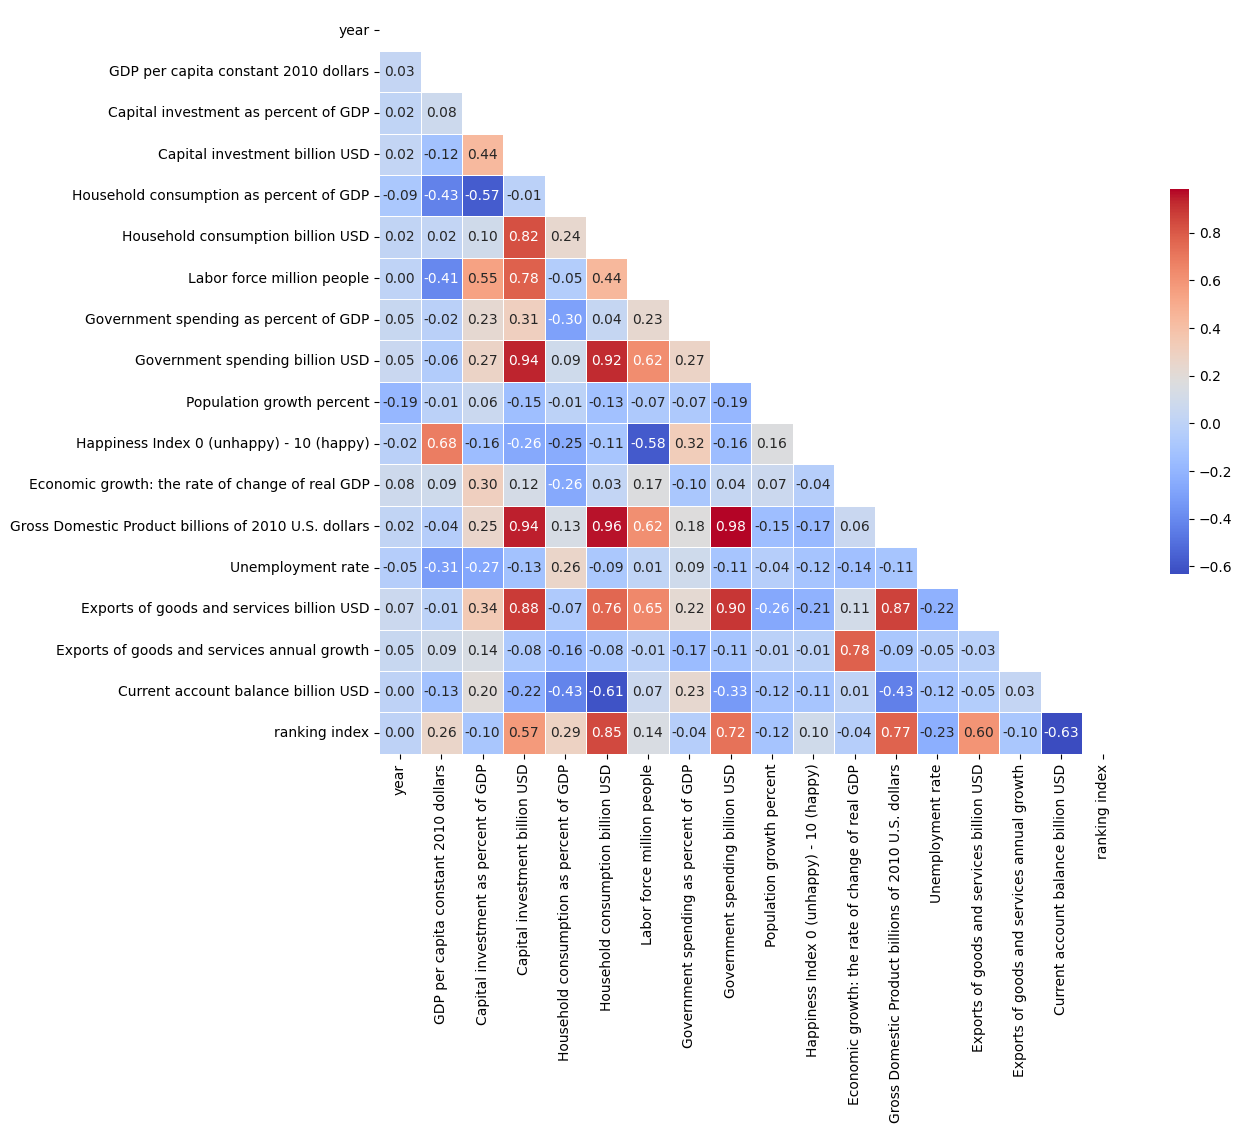

In [78]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm",
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [27]:
high_corr_pairs = corr_matrix.abs().unstack().sort_values(kind="quicksort", ascending=False)

# Filter out pairs of the same variable (correlation of 1) and lower correlations
high_corr_pairs = high_corr_pairs[high_corr_pairs < 1]
high_corr_pairs = high_corr_pairs[high_corr_pairs >= 0.7]

high_corr_pairs

Gross Domestic Product billions of 2010 U.S. dollars  Government spending billion USD                         0.982074
Government spending billion USD                       Gross Domestic Product billions of 2010 U.S. dollars    0.982074
Gross Domestic Product billions of 2010 U.S. dollars  Household consumption billion USD                       0.961335
Household consumption billion USD                     Gross Domestic Product billions of 2010 U.S. dollars    0.961335
Capital investment billion USD                        Gross Domestic Product billions of 2010 U.S. dollars    0.940435
Gross Domestic Product billions of 2010 U.S. dollars  Capital investment billion USD                          0.940435
Capital investment billion USD                        Government spending billion USD                         0.936655
Government spending billion USD                       Capital investment billion USD                          0.936655
                                                

#### step2: Random Forest for Visualizing Feature Importance

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

In [29]:
X = df.drop(['country', 'Code', 'ContinentCode', 'year', 'ranking index'], axis=1)
y = df['ranking index']
scaler = StandardScaler()
X_scaled = StandardScaler().fit_transform(X)

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_scaled, y)

RandomForestRegressor()

In [30]:
importances = rf.feature_importances_

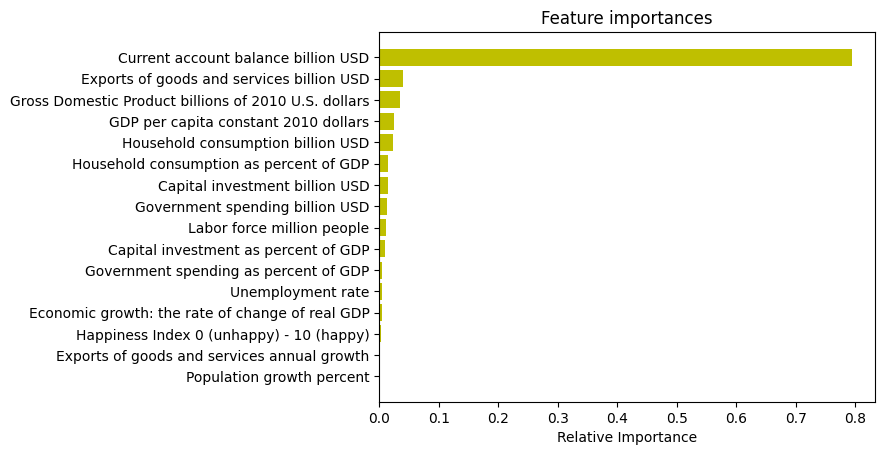

In [76]:
features = X.columns
indices = np.argsort(importances)

plt.title("Feature importances")
plt.barh(range(len(indices)), importances[indices], color="y", align="center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### step2: Predictors' Time Series

In [7]:
import plotly.graph_objs as go

variables = [
    "Capital investment billion USD",
    "Household consumption billion USD",
    "Government spending billion USD",
    "Gross Domestic Product billions of 2010 U.S. dollars",
    "Exports of goods and services billion USD",
    "Current account balance billion USD"
]

for variable in variables:

  fig = go.Figure()

  for country in df['country'].unique():
      df_country = df[df['country'] == country]
      fig.add_trace(go.Scatter(
          x=df_country['year'],
          y=df_country[variable],
          name=country,
          visible=True
      ))

  buttons = [
      dict(label='All Countries',
          method='update',
          args=[{'visible': [True] * len(df['country'].unique())},  # Set all traces to visible
                {'title': f'{variable} Over Years by Country'}])
  ]

  for country in df['country'].unique():
      visible_list = [country == c for c in df['country'].unique()]
      buttons.append(
          dict(label=country,
              method='update',
              args=[{'visible': visible_list},
                    {'title': f'{variable} Over Years: {country}'}])
      )

  fig.update_layout(
      updatemenus=[
          go.layout.Updatemenu(
              buttons=buttons,
              direction='down',
              pad={'r': 10, 't': 10},
              showactive=True,
              x=0,
              xanchor='left',
              y=1.1,
              yanchor='top',
              bgcolor='#AAAAAA',
              bordercolor='#FFFFFF',
              font=dict(size=11, color='#000000')
          )
      ],
      title=f'{variable} Over Years by Country'
  )

  fig.update_xaxes(title_text='Year')
  fig.update_yaxes(title_text=f'{variable}')

  fig.show()

### step3: Map of Rank Index

In [8]:
import plotly.express as px

# Determine the fixed range for the color scale
# This could be based on the min and max of the "ranking index" or a range you decide
color_scale_min = df['ranking index'].min()
color_scale_max = df['ranking index'].max()

# Create the map with a fixed color scale
fig = px.choropleth(
    df,
    locations="Code",
    color="ranking index",
    hover_name="country",
    animation_frame="year",
    color_continuous_scale=px.colors.sequential.Plasma,  # Using blue color scale
    range_color=[color_scale_min, color_scale_max],  # Set the fixed range for the color scale
    projection="natural earth",
    title="Country Ranking Index Over Years"
)

# Set the layout for the slider
fig.layout.sliders[0].pad.t = 10

# Show the figure
fig.show()

### Step 4: Linear Relationship Visualization

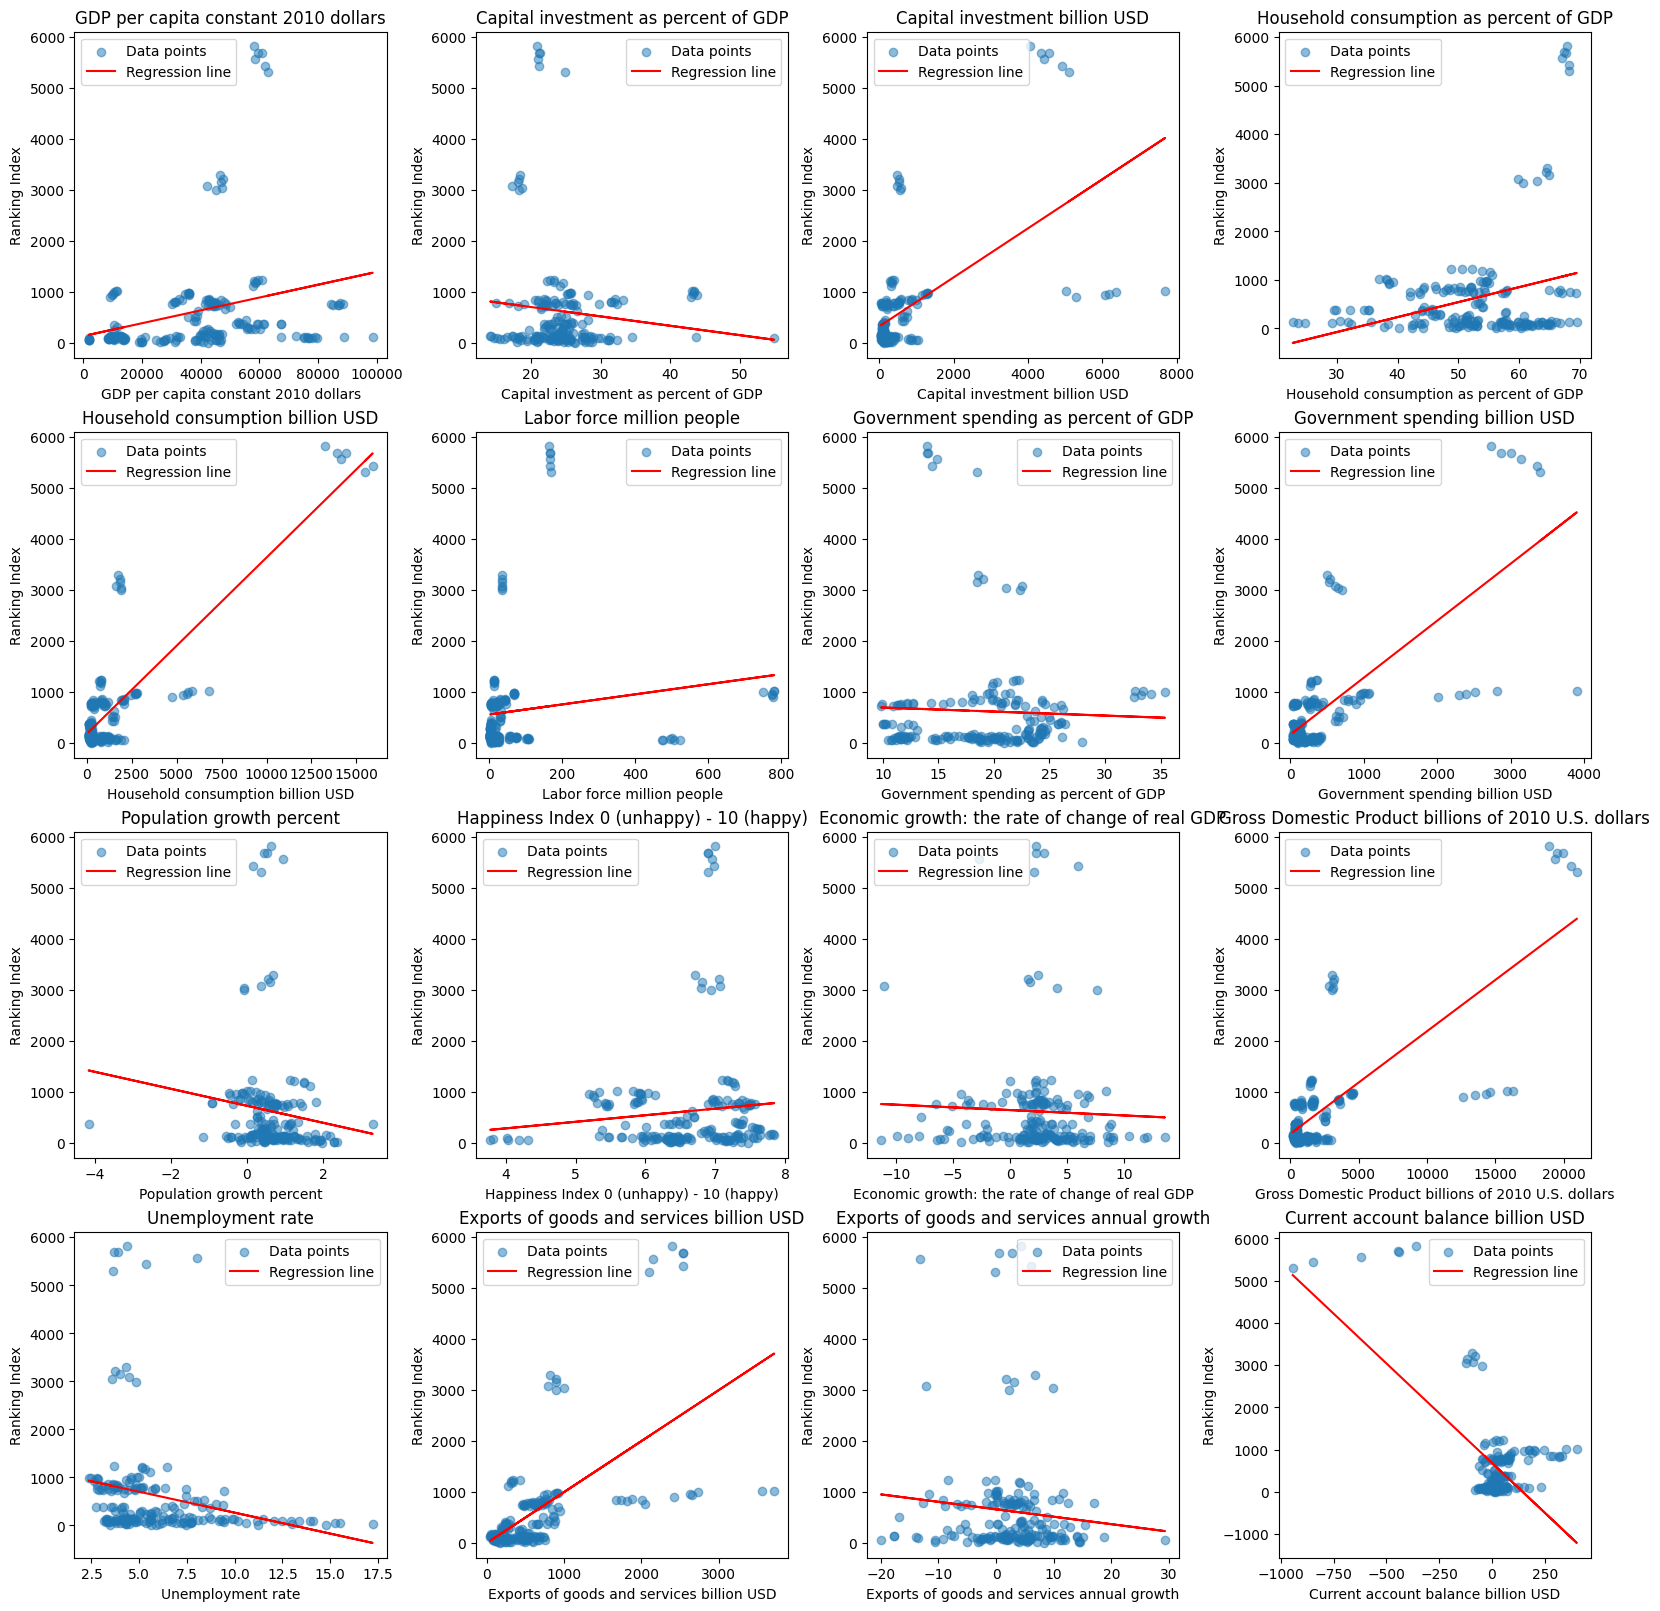

In [59]:
num_plots = len(X.columns)
num_rows = (num_plots + 3) // 4  # This ensures that we have enough rows for all predictors
num_cols = 4  # We want 4 columns

# Create a 4x4 matrix of subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 4 * num_rows), constrained_layout=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot individual regressions
for i, column in enumerate(X.columns):
    # Add a constant term to the predictor
    X_col = sm.add_constant(df[[column]])

    # Fit the model
    model = sm.OLS(y, X_col).fit()

    # Only scatter plot and regression line if we have an axis to plot on
    if i < num_cols * num_rows:
        ax = axes[i]

        # Scatter plot
        ax.scatter(df[column], y, alpha=0.5, label='Data points')

        # Regression line
        ax.plot(df[column], model.predict(X_col), color='red', label='Regression line')

        # Labels and title
        ax.set_xlabel(column)
        ax.set_ylabel('Ranking Index')
        ax.set_title(f'{column}')
        ax.legend()

# Hide any remaining axes if there are fewer than 16 predictors
if num_plots < num_cols * num_rows:
    for j in range(num_plots, num_cols * num_rows):
        fig.delaxes(axes[j])

plt.show()


# Modeling

## Part 1: Lasso Regression

$ Ranking Index = \beta_0 + \beta_1 (\text{GDP}) + \beta_2 (\text{GDP growth}) + \beta_3 x_3 + \cdots + \beta_n x_n + \varepsilon $

We choose to proceed with Lasso because:
- Model Assumptions: LASSO assumes a linear relationship between features and the target variable
- Overfitting: LASSO, with its regularization, inherently prevents overfitting. If your dataset is small or noisy, LASSO's feature selection might generalize better.
- Interpretability: LASSO provides a more straightforward explanation by selecting a smaller subset of features with linear coefficients.
- Model Purpose: Because the purpose of the model is for inference, understanding which features are important and their relationship with the target, LASSO is more preferable over random forest.

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

In [73]:
lasso_model = LassoCV(cv=5, random_state=0)
lasso_model.fit(X_train, y_train)

LassoCV(cv=5, random_state=0)

#### Lasso Path

<ipython-input-75-966d3e1bd35b>:4: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



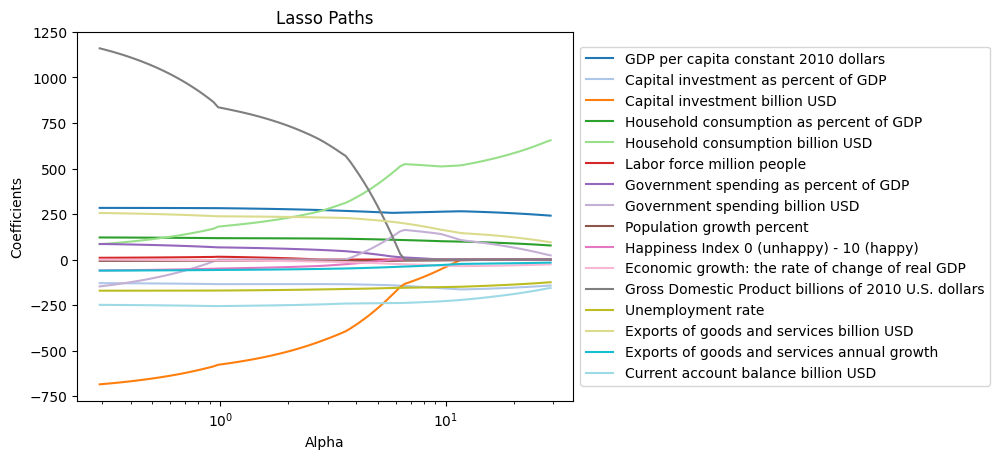

In [75]:
alphas_lasso, coefs_lasso, _ = lasso_path(X_train, y_train, alphas=np.geomspace(lasso_model.alpha_ * 10, lasso_model.alpha_ / 10, num=100))

num_lines = coefs_lasso.shape[0]
colors = plt.cm.get_cmap('tab20', num_lines)

for i, (coef_l, feature) in enumerate(zip(coefs_lasso, X.columns)):
    plt.plot(alphas_lasso, coef_l, label=feature, color=colors(i))

plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso Paths')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Place legend outside the plot
plt.xscale('log')
plt.axis('tight')
plt.show()

In [79]:
print(f"Best alpha: {lasso_model.alpha_}")

Best alpha: 2.9184026880155245


#### Non-zero Coefficients

In [80]:
coef_dict = {df.columns[i+4]: lasso_model.coef_[i] for i in range(len(df.columns)-5)}
pd.DataFrame(list(coef_dict.items()), columns=['Variable', 'Coefficient']).set_index('Variable')

,Coefficient
Variable,
GDP per capita constant 2010 dollars,285.726175
Capital investment as percent of GDP,-148.145333
Capital investment billion USD,-399.306233
Household consumption as percent of GDP,127.680712
Household consumption billion USD,0.000000
Labor force million people,-134.878435
Government spending as percent of GDP,95.674224
Government spending billion USD,-0.000000
Population growth percent,11.804540


These features are assigned with 0 coefficient: Index(['Household consumption billion USD', 'Government spending billion USD'], dtype='object')


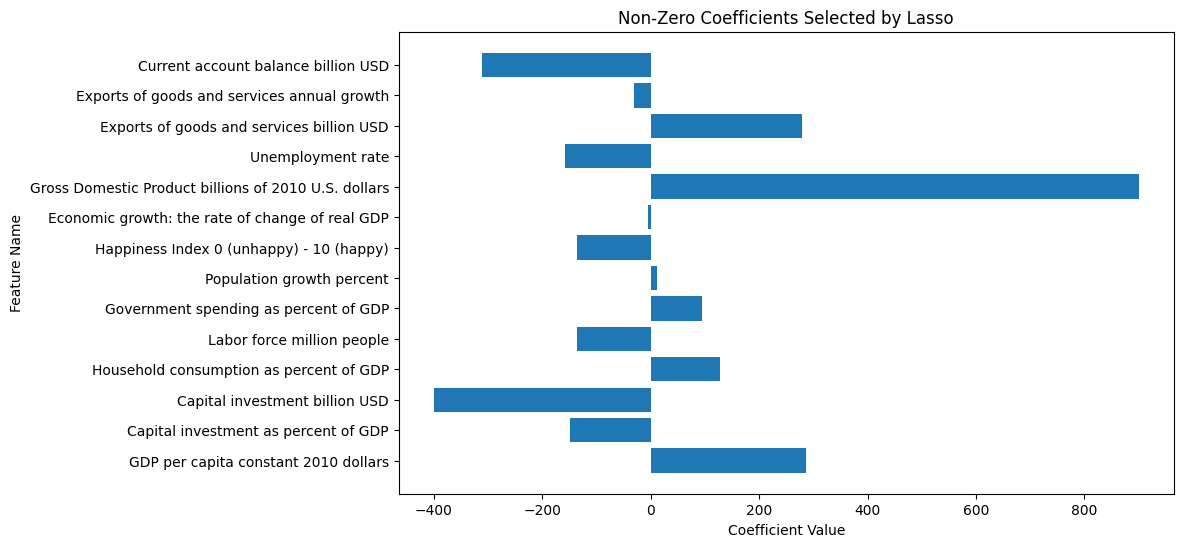

In [81]:
coefs = lasso_model.coef_
features = X.columns

selected_features = features[coefs != 0]
selected_coefs = coefs[coefs != 0]
unselected_features = features[coefs == 0]
print(f"These features are assigned with 0 coefficient: {unselected_features}")

plt.figure(figsize=(10, 6))
plt.barh(selected_features, selected_coefs)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('Non-Zero Coefficients Selected by Lasso')
plt.show()

- As we could see from the OLS result table above, the coefficient on the variable 'Gross Domestic Product billions of 2010 U.S. dollars' is -8.911e-05, the associated p-value is 0.304, which is statistically insignificant at the 5% level.
- And the coefficient on the variable 'Economic growth: the rate of change of real GDP' is -0.0014, the associated p-value is 0.959, which is statistically insignificant at the 5% level as well.
- But the coefficient on 'GDP per capita constant 2010 dollars' has a p-value of 0, which is statistically significant at the 5% level.

In [82]:
y_pred = lasso_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

lasso_results = {
    "Mean Squared Error": mse,
    "R-squared": r2
}

pd.DataFrame([lasso_results])

,Mean Squared Error,R-squared
0,245151.174378,0.854286


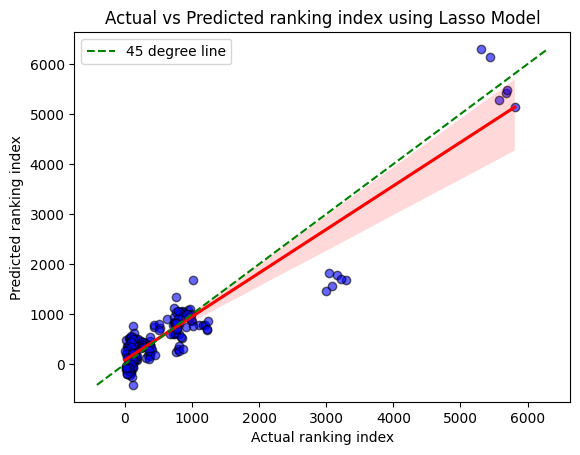

In [101]:
lasso_model_full = LassoCV(cv=5, random_state=0, max_iter=10000).fit(X_scaled, y)

y_full_pred = lasso_model_full.predict(X_scaled)

plt.scatter(y, y_full_pred, color='blue', alpha=0.6, edgecolor='k')
sns.regplot(x=y, y=y_full_pred, scatter=False, color='r')

plt.xlabel('Actual ranking index')
plt.ylabel('Predicted ranking index')
plt.title('Actual vs Predicted ranking index using Lasso Model')

min_val = min(y.min(), y_full_pred.min())
max_val = max(y.max(), y_full_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='green', linestyle='--', label='45 degree line')


plt.legend()
plt.show()


## Part 2: Two-stage least squares (2SLS) regression

- As the OLS model above is likely suffer from endogeneity issues (reverse causality: better university is likely lead to a higher GDP of the country, and omitted variable bias : there are too many variables correlated with both the university ranking of a country and its GDP, and we may not be able to get data and control all of them). Therefore, here we include the 2SLS model to deal with the problem of endogeneity.

- In this model, to test the effect of 'Gross Domestic Product billions of 2010 U.S. dollars' on log of ranking index, the instrument we have chosen is 'Exports of goods and services billion USD', as it satisfies the three conditions for instruments, which are first stage, exogeneity and exclusion.

### 1. first stage

$$
\text{Gross Domestic Product billions of 2010 U.S. dollars}_i = \delta_0 + \delta_1 \text{Exports of goods and services billion USD}_i + v_i
$$

In [ ]:
# test the first stage
results_fs = sm.OLS(df['Gross Domestic Product billions of 2010 U.S. dollars'],
                    df[['const', 'Exports of goods and services billion USD']]).fit()
print(results_fs.summary())

                                             OLS Regression Results                                             
Dep. Variable:     Gross Domestic Product billions of 2010 U.S. dollars   R-squared:                       0.749
Model:                                                              OLS   Adj. R-squared:                  0.747
Method:                                                   Least Squares   F-statistic:                     566.3
Date:                                                  Sat, 09 Dec 2023   Prob (F-statistic):           6.80e-59
Time:                                                          23:02:12   Log-Likelihood:                -1735.8
No. Observations:                                                   192   AIC:                             3476.
Df Residuals:                                                       190   BIC:                             3482.
Df Model:                                                             1                         

- As we see from the table, the coefficient is large and the p-value is 0 which is lower than 0.05, therefore the instrument is correlated with the GDP. -> satisfies the first condition for instrument we mentioned above

- We cannot directly test whether the instrument is correlated with the error term or not (exogeneity and exclusion). But intuitively, the export should not correlated with the ranking index except for the fact that it inflences GDP. As we could see from the QS ranking calculation, none of the considered factors (Sustainability, Employment outcomes, International research network, etc.) seem related to the export of countries. Therefore we could infer export is a viable instrument in this case.

### 2. second stage

$$
\log(\text{ranking index})_i = \beta_0 + \beta_1 \widehat{\text{GDP}}_i + u_i
$$

In [ ]:
df['predicted_gdp'] = results_fs.predict()

results_ss = sm.OLS(y_log,
                    df[['const', 'predicted_gdp']]).fit()
print(results_ss.summary())

                            OLS Regression Results                            
Dep. Variable:          ranking index   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     95.69
Date:                Sat, 09 Dec 2023   Prob (F-statistic):           1.47e-18
Time:                        23:02:13   Log-Likelihood:                -292.83
No. Observations:                 192   AIC:                             589.7
Df Residuals:                     190   BIC:                             596.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.0409      0.095     52.935

### 3. directly using linearmodels package (IV2SLS)

In [ ]:
iv = IV2SLS(dependent = y_log,
            exog = df['const'],
            endog = df['Gross Domestic Product billions of 2010 U.S. dollars'],
            instruments = df['Exports of goods and services billion USD']).fit(cov_type='unadjusted')

print(iv.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:          ranking index   R-squared:                      0.2465
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2426
No. Observations:                 192   F-statistic:                    85.351
Date:                Sat, Dec 09 2023   P-value (F-stat)                0.0000
Time:                        23:02:18   Distribution:                  chi2(1)
Cov. Estimator:            unadjusted                                         
                                                                              
                                                  Parameter Estimates                                                   
                                                      Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------------------------------------------
const

- the package give us the same coefficient as we get from the first stage second stage analysis, therefore in the next part we directly use the iv package

### 4. testing the effect of GDP growth on ranking index

- for testing the impact of GDP gowth on log ranking index, we change the instrument to 'Exports of goods and services annual growth'

In [ ]:
# first stage
results_fs = sm.OLS(df['Economic growth: the rate of change of real GDP'],
                    df[['const', 'Exports of goods and services annual growth']]).fit()
print(results_fs.summary())

                                           OLS Regression Results                                          
Dep. Variable:     Economic growth: the rate of change of real GDP   R-squared:                       0.607
Model:                                                         OLS   Adj. R-squared:                  0.605
Method:                                              Least Squares   F-statistic:                     293.3
Date:                                             Sat, 09 Dec 2023   Prob (F-statistic):           2.25e-40
Time:                                                     23:02:19   Log-Likelihood:                -448.93
No. Observations:                                              192   AIC:                             901.9
Df Residuals:                                                  190   BIC:                             908.4
Df Model:                                                        1                                         
Covariance Type:            

In [ ]:
# 2SLS
iv2 = IV2SLS(dependent = y_log,
            exog = df['const'],
            endog = df['Economic growth: the rate of change of real GDP'],
            instruments = df['Exports of goods and services annual growth']).fit(cov_type='unadjusted')

print(iv2.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:          ranking index   R-squared:                     -0.0021
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0073
No. Observations:                 192   F-statistic:                    2.4172
Date:                Sat, Dec 09 2023   P-value (F-stat)                0.1200
Time:                        23:02:26   Distribution:                  chi2(1)
Cov. Estimator:            unadjusted                                         
                                                                              
                                                Parameter Estimates                                                
                                                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------------------------------
const               

## Part 3: 2SLS with LASSO Selected IV


Combining 2SLS with LASSO involves integrating the LASSO approach into one or both stages of the 2SLS process. This can be particularly useful in situations where there are many potential instruments or covariates, as LASSO can help in selecting the most relevant ones. In the first stage, LASSO can be used to select instruments and reduce dimensionality. In the second stage, it can be applied to the main regression to continue the feature selection process and enhance model interpretability.

This combination of 2SLS and LASSO can be very powerful for dealing with high-dimensional data in the presence of endogeneity, although it requires careful consideration of the assumptions and conditions under which the instruments and covariates are selected.

### 1st Stage: Use LASSO to select IV

In [85]:
predictors = df.drop(columns=['country', 'Code', 'ContinentCode', 'year',
                              'Gross Domestic Product billions of 2010 U.S. dollars',
                              'ranking index'])

endog_variable = df['Gross Domestic Product billions of 2010 U.S. dollars']

scaler = StandardScaler()
X_standardized = scaler.fit_transform(predictors)

X_train, X_test, y_train, y_test = train_test_split(
    X_standardized, endog_variable, test_size=0.2, random_state=0
)

lasso_cv = LassoCV(cv=5, random_state=0, max_iter=10000).fit(X_train, y_train)

train_selected_features = predictors.columns[(lasso_cv.coef_ != 0)]

train_selected_features, lasso_cv.alpha_


(Index(['Capital investment billion USD', 'Household consumption billion USD',
        'Labor force million people', 'Government spending billion USD'],
       dtype='object'),
 49.53573555164663)

#### LASSO Path

<ipython-input-88-73d2f5034374>:4: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



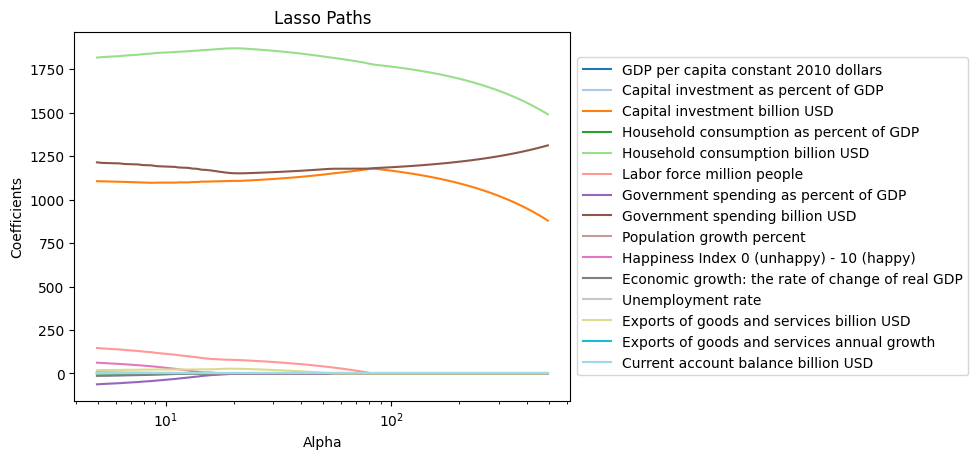

In [88]:
alphas_lasso, coefs_lasso, _ = lasso_path(X_standardized, endog_variable, alphas=np.geomspace(lasso_cv.alpha_ * 10, lasso_cv.alpha_ / 10, num=100))

num_lines = coefs_lasso.shape[0]
colors = plt.cm.get_cmap('tab20', num_lines)

for i, (coef_l, feature) in enumerate(zip(coefs_lasso, predictors.columns)):
    plt.plot(alphas_lasso, coef_l, label=feature, color=colors(i))

plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso Paths')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Place legend outside the plot
plt.xscale('log')
plt.axis('tight')
plt.show()

#### Non-zero Coefficients

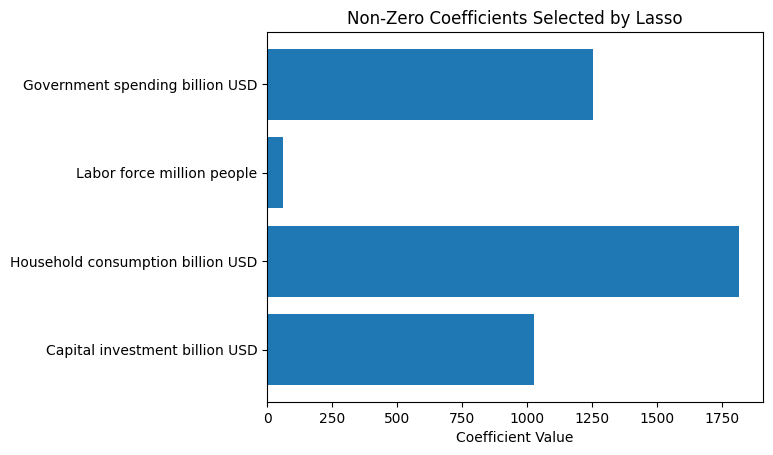

In [89]:
non_zero_columns = predictors.columns[(lasso_cv.coef_ != 0)]
non_zero_coefs = lasso_cv.coef_[lasso_cv.coef_ != 0]

plt.barh(non_zero_columns, non_zero_coefs)
plt.xlabel('Coefficient Value')
plt.title('Non-Zero Coefficients Selected by Lasso')
plt.show()


### 2nd Stage: Estimating 'Ranking Index' Using endo + control

In [90]:
# For the second stage, we fit the model on the training set using only the selected features
X_train_selected = X_train[:, lasso_cv.coef_ != 0]

lasso2sls_model = LinearRegression().fit(X_train_selected, y_train)
X_test_selected = X_test[:, lasso_cv.coef_ != 0]

y_pred = lasso2sls_model.predict(X_test_selected)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

lasso2sls_results = {
    "Mean Squared Error": mse,
    "R-squared": r2
}

pd.DataFrame([lasso2sls_results])

,Mean Squared Error,R-squared
0,54516.241266,0.997848


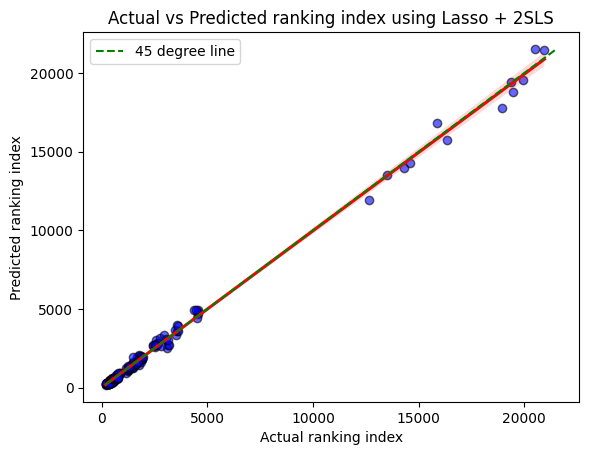

In [98]:
# Fit the lasso model on the entire standardized dataset with selected features
X_full_selected = X_standardized[:, lasso_cv.coef_ != 0]
lasso2sls_model_full = LassoCV(cv=5, random_state=0, max_iter=10000).fit(X_full_selected, endog_variable)

y_full_pred = lasso2sls_model_full.predict(X_full_selected)

plt.scatter(endog_variable, y_full_pred, color='blue', alpha=0.6, edgecolor='k')
sns.regplot(x=endog_variable, y=y_full_pred, scatter=False, color='red')

min_val = min(endog_variable.min(), y_full_pred.min())
max_val = max(endog_variable.max(), y_full_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='green', linestyle='--', label='45 degree line')


plt.xlabel('Actual ranking index')
plt.ylabel('Predicted ranking index')
plt.title('Actual vs Predicted ranking index using Lasso + 2SLS')

plt.legend()
plt.show()


## Result analysis

## Conclusion and limitation

## Appendix : Github repository link